In [20]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scipy.spatial.distance import euclidean
from collections import Counter
import random

In [2]:
record = wfdb.rdrecord('200', pn_dir='mitdb')
annotation = wfdb.rdann('200', 'atr', pn_dir='mitdb')
signal = record.p_signal[:,0]
fs = record.fs
t = np.arange(len(signal)) / fs

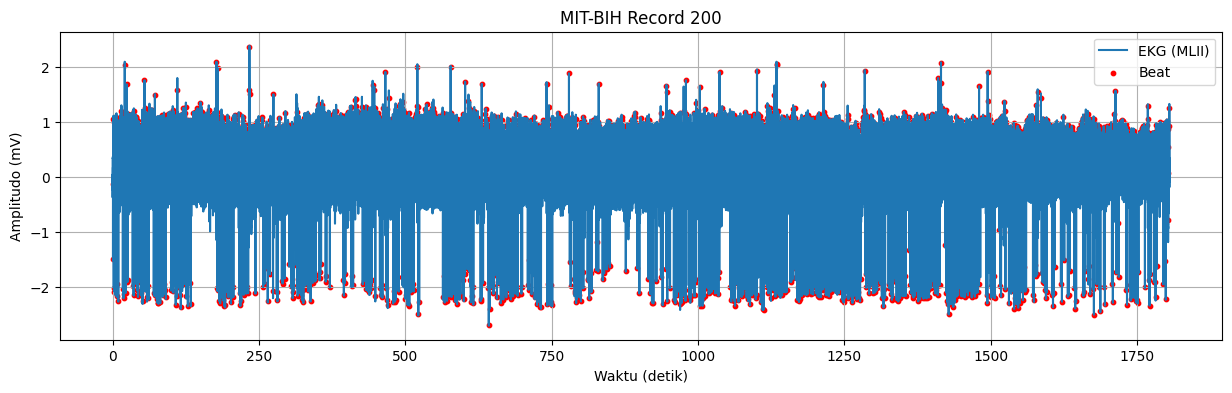

In [3]:
plt.figure(figsize=(15, 4))
plt.plot(t, signal, label='EKG (MLII)')
plt.title('MIT-BIH Record 200')
plt.xlabel('Waktu (detik)')
plt.ylabel('Amplitudo (mV)')
plt.scatter(annotation.sample / fs, signal[annotation.sample], color='red', s=10, label='Beat')
plt.legend()
plt.grid(True)
plt.show()

Feature Extraction

In [4]:
rr_intervals = np.diff(annotation.sample)
rr_intervals

array([158, 262, 202, ..., 166, 256, 263], shape=(2791,))

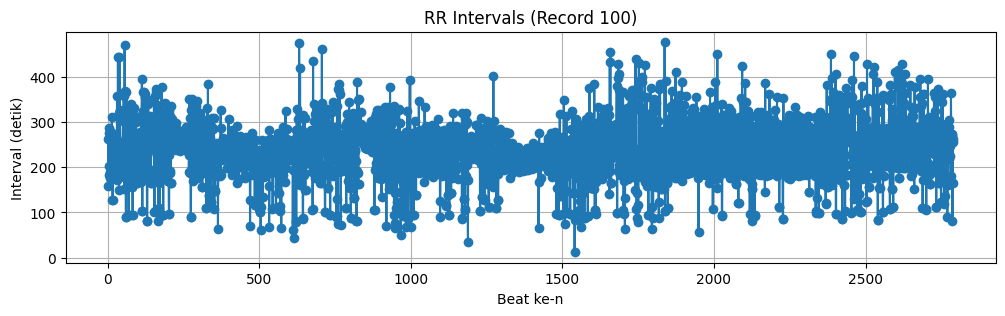

In [5]:
plt.figure(figsize=(12, 3))
plt.plot(rr_intervals, marker='o')
plt.title('RR Intervals (Record 100)')
plt.xlabel('Beat ke-n')
plt.ylabel('Interval (detik)')
plt.grid(True)
plt.show()

In [6]:
beat_samples = annotation.sample
labels = annotation.symbol
fs = record.fs
signal = record.p_signal[:,0]

In [7]:
Counter(annotation.symbol)

Counter({'N': 1743, 'V': 826, '+': 148, '~': 43, 'A': 30, 'F': 2})

In [8]:
features = []
for i in range(1, len(beat_samples)):
    current = beat_samples[i]
    previous = beat_samples[i-1]

    rr = (current-previous) / fs

    win_size = int(0.2*fs)
    start = max(current - win_size, 0)
    end = min(current + win_size, len(signal))
    window = signal[start:end]

    rms = np.sqrt(np.mean(window**2))
    ptp = np.ptp(window)

    features.append({
        'rr_interval': rr,
        'rms': rms,
        'ptp': ptp,
        'label': labels[i]
    })
df = pd.DataFrame(features)
df

,rr_interval,rms,ptp,label
0,0.438889,0.514552,1.890,V
1,0.727778,0.331808,1.650,N
2,0.561111,0.708518,2.875,V
3,0.763889,0.356378,1.545,N
4,0.508333,0.727836,2.660,V
...,...,...,...,...
2786,0.727778,0.829820,1.285,N
2787,0.225000,0.811444,0.625,~
2788,0.461111,0.354908,1.370,N
2789,0.711111,0.215889,1.085,N


In [9]:
df = df[df['label'].isin(['N', 'V'])].dropna()
df

,rr_interval,rms,ptp,label
0,0.438889,0.514552,1.890,V
1,0.727778,0.331808,1.650,N
2,0.561111,0.708518,2.875,V
3,0.763889,0.356378,1.545,N
4,0.508333,0.727836,2.660,V
...,...,...,...,...
2785,0.750000,0.446444,1.170,N
2786,0.727778,0.829820,1.285,N
2788,0.461111,0.354908,1.370,N
2789,0.711111,0.215889,1.085,N


In [10]:
df['target'] = df['label'].map({'N': 0, 'V': 1})
df

,rr_interval,rms,ptp,label,target
0,0.438889,0.514552,1.890,V,1
1,0.727778,0.331808,1.650,N,0
2,0.561111,0.708518,2.875,V,1
3,0.763889,0.356378,1.545,N,0
4,0.508333,0.727836,2.660,V,1
...,...,...,...,...,...
2785,0.750000,0.446444,1.170,N,0
2786,0.727778,0.829820,1.285,N,0
2788,0.461111,0.354908,1.370,N,0
2789,0.711111,0.215889,1.085,N,0


In [11]:
X = df[['rr_interval', 'rms', 'ptp']].values
y = df['target'].values

In [12]:
df['label'].value_counts()

label
N    1743
V     826
Name: count, dtype: int64

In [13]:
X_self = X[y == 0]
X_nonself = X[y == 1]

In [14]:
X_train_self, X_test_self = train_test_split(X_self, test_size=0.3, random_state=1)
X_train_nonself, X_test_nonself = train_test_split(X_nonself, test_size=0.3, random_state=1)

In [15]:
n_detectors = 100
r = 0.1

In [16]:
detectors = []
while len(detectors) < n_detectors :
    candidate = X_train_nonself[np.random.choice(len(X_train_nonself))]
    if all(euclidean(candidate, s) > r for s in X_train_self):
        detectors.append(candidate)

def detect(x) :
    for d in detectors:
        if euclidean(x , d)  < r :
            return 1 
    return 0


In [17]:
X_test = np.vstack([X_test_self, X_test_nonself])
y_test = np.array([0]*len(X_test_self) + [1]*len(X_test_nonself))
y_pred = [detect(x) for x in X_test]

In [18]:
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi NSA: {acc:.2f}")

Akurasi NSA: 0.95


In [21]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Normal (N)', 'PVC (V)']))

[[523   0]
 [ 37 211]]
              precision    recall  f1-score   support

  Normal (N)       0.93      1.00      0.97       523
     PVC (V)       1.00      0.85      0.92       248

    accuracy                           0.95       771
   macro avg       0.97      0.93      0.94       771
weighted avg       0.96      0.95      0.95       771



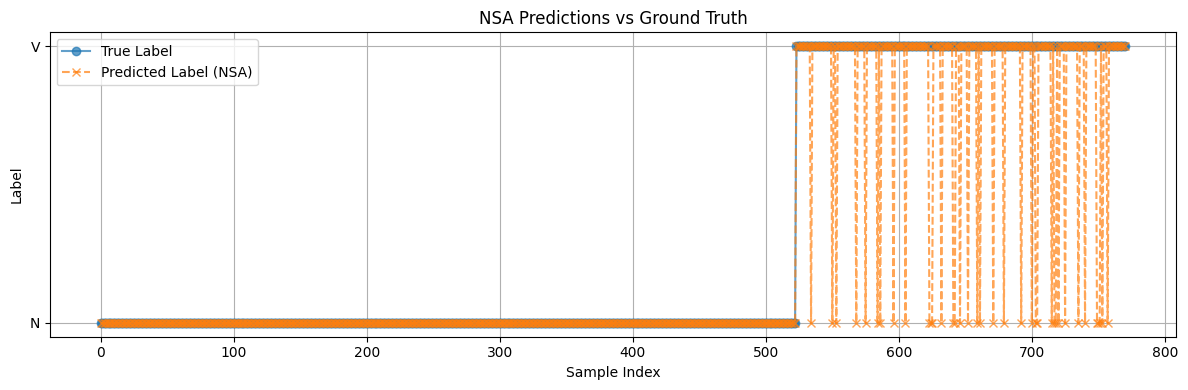

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(y_test, label='True Label', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred, label='Predicted Label (NSA)', marker='x', linestyle='--', alpha=0.7)
plt.title('NSA Predictions vs Ground Truth')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.yticks([0, 1], ['N', 'V'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()